In [29]:
import argparse
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import pydot
import matplotlib.pyplot as plt

parser = argparse.ArgumentParser()

parser.add_argument("--dataset",
    type=lambda expr: [
        os.path.abspath("../DataFiles/{}".format(r)) for r in expr.split(",")],
    default="xsede_revised.csv",
    help="dataset file name or list of dataset files separated by comma.")

_StoreAction(option_strings=['--dataset'], dest='dataset', nargs=None, const=None, default='xsede_revised.csv', type=<function <lambda> at 0x12b3118b0>, choices=None, help='dataset file name or list of dataset files separated by comma.', metavar=None)

In [30]:
#dataset_file_location is a "list" of considered dataset files
#function takes a list and return a dataframe created from provided locations.
#capable of creating a single dataframe for multiple data file locations

def load_dataset_from_file(dataset_file_location):
    result_df=pd.read_csv(dataset_file_location)
    return result_df


def extractRequiredColumn(df,requiredFields):
    return df[df.columns[df.columns.isin(requiredFields)]]

def NormalizeData(df):
    df_no_NA=df.replace(to_replace="na",value= 1).astype(float) # line replace any 'na' in the dataset with 0
    return df_no_NA/df_no_NA.max()

def set_labels(dataFrame,LabelName):
    return np.array(dataFrame[LabelName])

def set_features(dataFrame,LabelName,dropFeatureList):
    dataFrame= dataFrame.drop(LabelName, axis = 1)
    for i in dropFeatureList:
        dataFrame= dataFrame.drop(i, axis = 1)
    feature_list=list(dataFrame.columns)
    return np.array(dataFrame),feature_list

class ReadFile:
    def __init__(self,
                dataset_file_location,requiredFields):

        #dataset_file_location is a "list" of considered dataset files
        self.dataset=load_dataset_from_file(dataset_file_location)
        self.requiredData=extractRequiredColumn(self.dataset,requiredFields)
        self.requiredNormalizedData=NormalizeData(self.requiredData)

class pd2Array:
    def __init__(self,dataFrame,LabelName,dropFeatureList):

        self.labels=set_labels(dataFrame,LabelName)
        self.features,self.feature_list=set_features(dataFrame,LabelName,dropFeatureList)

In [35]:
if __name__ == "__main__":
#     args = parser.parse_args()
    #requiredFields is a list of the fields containing attributes and the output
    requiredFields=['FileSize', 'FileCount',
   'Bandwidth', 'RTT', 'BufferSize', 'Parallelism', 'Concurrency',
   'Pipelining', 'Throughput']
    LabelName='Throughput'
    dropFeatureList=['Parallelism', 'Concurrency',
   'Pipelining']
   # fileData is an object of ReadFile class
    dataset="../DataFiles/xsede_revised.csv"
    fileData=ReadFile(dataset,requiredFields)
    print(fileData.requiredNormalizedData.describe())

    

   

           FileSize     FileCount  Bandwidth           RTT    BufferSize  \
count  11324.000000  11324.000000    11324.0  11324.000000  11324.000000   
mean       0.127780      0.020047        1.0      0.828553      0.996073   
std        0.194730      0.080649        0.0      0.103877      0.008692   
min        0.000098      0.000048        1.0      0.634921      0.976837   
25%        0.001563      0.000048        1.0      0.793651      1.000000   
50%        0.033438      0.001194        1.0      0.793651      1.000000   
75%        0.192637      0.012227        1.0      0.952381      1.000000   
max        1.000000      1.000000        1.0      1.000000      1.000000   

        Parallelism   Concurrency    Pipelining    Throughput  
count  11324.000000  11324.000000  11324.000000  11324.000000  
mean       0.133658      0.164645      0.043565      0.131316  
std        0.161579      0.252020      0.089223      0.112279  
min        0.015625      0.031250      0.000000      0.0006

In [32]:
    processedData=pd2Array(fileData.requiredNormalizedData,LabelName,dropFeatureList)
    # print(processedData.labels,len(processedData.labels)) # processedData.labels is np.array
    # print(processedData.features,processedData.features.shape) #processedData.features are dataFrame

    train_features, test_features, train_labels, test_labels = train_test_split(processedData.features, processedData.labels, test_size = 0.25, random_state = 42)
    # print('Training Features Shape:', train_features.shape)
    # print('Training Labels Shape:', train_labels.shape)
    # print('Testing Features Shape:', test_features.shape)
    # print('Testing Labels Shape:', test_labels.shape)


    rf = RandomForestRegressor(n_estimators = 1000, min_samples_leaf=1, random_state = 42)
    rf.fit(train_features, train_labels)

    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features)
    # Calculate the absolute errors
    errors = abs(predictions - test_labels)
    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.05


In [33]:
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / test_labels)
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')
    tree = rf.estimators_[5]
    export_graphviz(tree, out_file = 'tree.dot', feature_names = processedData.feature_list, rounded = True, precision = 1)
    # Use dot file to create a graph
    (graph, ) = pydot.graph_from_dot_file('./tree.dot')
    # Write graph to a png file
    graph.write_png('tree.png')

        # Limit depth of tree to 3 levels
    rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
    rf_small.fit(train_features, train_labels)
    # Extract the small tree
    tree_small = rf_small.estimators_[5]
    # Save the tree as a png image
    export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = processedData.feature_list, rounded = True, precision = 1)
    (graph, ) = pydot.graph_from_dot_file('small_tree.dot')
    graph.write_png('small_tree.png')

Accuracy: 34.41 %.


Variable: FileSize             Importance: 0.45
Variable: FileCount            Importance: 0.33
Variable: RTT                  Importance: 0.17
Variable: BufferSize           Importance: 0.05
Variable: Bandwidth            Importance: 0.0


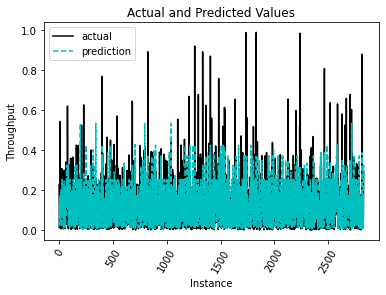

In [36]:
    # Get numerical feature importances
    importances = list(rf.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(processedData.feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

    instance=np.array([i for i in range(2831)])

    true_data = pd.DataFrame(data = {'Instance': instance, 'actual': test_labels})

    predictions_data = pd.DataFrame(data = {'Instance': instance, 'prediction': predictions})
    # Plot the actual values
    plt.plot(true_data['Instance'], true_data['actual'], 'k-', label = 'actual')
    # Plot the predicted values
    plt.plot(predictions_data['Instance'], predictions_data['prediction'], 'c--', label = 'prediction')
    plt.xticks(rotation = '60');
    plt.legend()
    # Graph labels
    plt.xlabel('Instance'); plt.ylabel('Throughput'); plt.title('Actual and Predicted Values')
    plt.show()